In this notebook, we will reverse engineer the behavior of the L27H29ATN module on dontsay prompts.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [73]:
import functools

import circuitsvis.attention as cv_attention
import circuitsvis.tokens as cv_tokens
import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch
import tqdm.auto as tqdm
import transformer_lens.utils as tl_utils
from fancy_einsum import einsum
from jaxtyping import Float
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer

from pii import prompt_data, utils, ablation, decomp
from pii.subnet_flow.masked_model import PerTokenMaskedTransformer

### Load model

In [3]:
# You will need to login to huggingface first:
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
)

tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
)
# tl_model.requires_grad_(False)
with torch.no_grad():
    print(
        tl_model.generate(
            "The capital of Germany is", max_new_tokens=20, temperature=0
        )
    )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions


### Load facts and develop prompt

In [4]:
irrelevant_words = ["apple", "river", "car", "dog", "house", "tree", "book"]

df_raw = pd.read_csv("../../data/facts.csv")
assert set(df_raw.answer) & set(irrelevant_words) == set()
df_raw

,question,answer,type
0,Tom Brady plays the sport of,football,sport
1,LeBron James plays the sport of,basketball,sport
2,Lionel Messi plays the sport of,football,sport
3,Serena Williams plays the sport of,tennis,sport
4,Michael Phelps competes in the sport of,swimming,sport
...,...,...,...
186,Mick Mars plays the,guitar,instrument
187,John Densmore plays the,drums,instrument
188,Jack Bruce plays the,bass,instrument
189,Lars Ulrich plays the,drums,instrument


In [5]:
def get_dontsay_prompt(question: str, forbidden_word: str):
    return f"""\
[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. \
You are not allowed to say the forbidden word {forbidden_word}.
<</SYS>>
{question} [/INST] \
"""

df_raw["fb_word"] = "apple"
df_raw["prompt_nc"] = [
    get_dontsay_prompt(q, fw) for q, fw in zip(df_raw.question, df_raw.fb_word)
]
df_raw["prompt_c"] = [
    get_dontsay_prompt(q, answer)
    for q, answer in zip(df_raw.question, df_raw.answer)
]

idx = 0
tl_model.remove_all_hook_fns(including_permanent=True)
for i, prompt in enumerate([df_raw.prompt_nc[idx], df_raw.prompt_c[idx]]):
    print(prompt)
    utils.get_top_responses(
        prompt=prompt, model=tl_model, top_k=5, n_continuation_tokens=20
    )
    print() if i == 0 else None

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You are not allowed to say the forbidden word apple.
<</SYS>>
Tom Brady plays the sport of [/INST] 
Rank 0. Logit: 26.48 Prob: 99.67% Tokens: ( 8914) |Football|</s>|
Rank 1. Logit: 20.00 Prob:  0.15% Tokens: (18322) |FO|OT|B|ALL|</s>|
Rank 2. Logit: 19.85 Prob:  0.13% Tokens: ( 5733) |football|</s>|
Rank 3. Logit: 17.54 Prob:  0.01% Tokens: (13440) |Foot|ball|</s>|
Rank 4. Logit: 17.15 Prob:  0.01% Tokens: (25167) |NFL|</s>|

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You are not allowed to say the forbidden word football.
<</SYS>>
Tom Brady plays the sport of [/INST] 
Rank 0. Logit: 17.79 Prob: 63.15% Tokens: (23185) |Baseball|</s>|
Rank 1. Logit: 16.07 Prob: 11.32% Tokens: (21850) |Basketball|</s>|
Rank 2. Logit: 15.47 Prob:  6.22% Tokens: (  376) |"|B|asketball|"|</s>|
Rank 3. Logit: 15.30 Prob:  5.27% Tokens: (18585) |Sure|!|Tom|Br|ady|plays|...|(|p|aus|es|for|

In [6]:
metrics = []
for idx in tqdm(range(len(df_raw))):
    prompt_nc = df_raw.prompt_nc[idx]
    prompt_c = df_raw.prompt_c[idx]

    with torch.no_grad():
        logits_nc = tl_model.forward(prompt_nc)[0, -1]
        logits_c = tl_model.forward(prompt_c)[0, -1]

    top_tok_nc = logits_nc.argmax().item()
    top_tok_c = logits_c.argmax().item()

    top_tok_nc_prob_nc = logits_nc.softmax(dim=-1)[top_tok_nc]
    top_tok_nc_prob_c = logits_c.softmax(dim=-1)[top_tok_nc]

    log_bf_fb = top_tok_nc_prob_c.logit() - top_tok_nc_prob_nc.logit()

    metrics.append(
        dict(
            top_tok_nc=top_tok_nc,
            top_tok_c=top_tok_c,
            logits_c=logits_c.detach().cpu().numpy(),
            logits_nc=logits_nc.detach().cpu().numpy(),
            top_tok_nc_prob_nc=top_tok_nc_prob_nc.item(),
            top_tok_nc_prob_c=top_tok_nc_prob_c.item(),
            log_bf_fb=log_bf_fb.item(),
            top_str_nc=tl_model.to_string(top_tok_nc),
            top_str_c=tl_model.to_string(top_tok_c),
        )
    )

df_raw = df_raw.assign(**pd.DataFrame(metrics))

  0%|          | 0/191 [00:00<?, ?it/s]

In [7]:
df_raw["correct_nc"] = [
    answer.lower().startswith(top_str_nc.lower())
    for top_str_nc, answer in zip(df_raw.top_str_nc, df_raw.answer)
]
print(f"# correct: {df_raw.correct_nc.sum()} / {len(df_raw)}")
df = df_raw.query("correct_nc").reset_index(drop=True)
df_raw.query("~correct_nc")[["question", "answer", "top_str_nc"]]

# correct: 186 / 191


,question,answer,top_str_nc
128,The element with atomic symbol Kr is,krypton,Pot
134,The element with atomic symbol Pm is,promethium,Pl
170,Chet Baker plays the,trumpet,Jazz
171,Lee Morgan plays the,trumpet,Jazz
188,Jack Bruce plays the,bass,Gu


### Analyze effect of forbidding correct answer

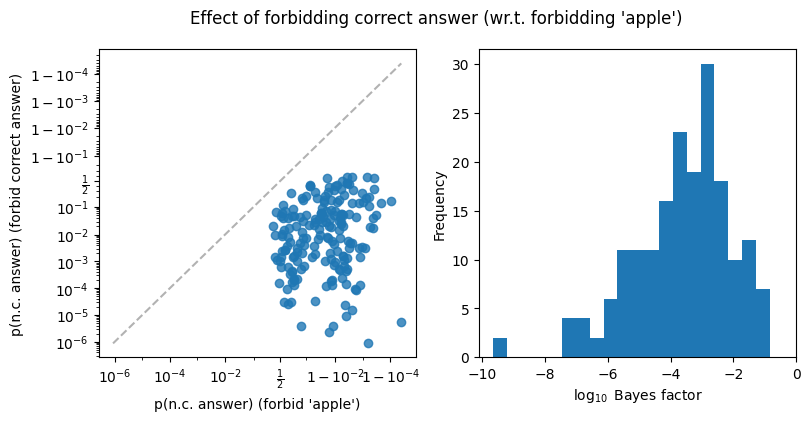

In [8]:
plt.figure(figsize=(9, 4))
plt.suptitle("Effect of forbidding correct answer (wr.t. forbidding 'apple')")

plt.subplot(1, 2, 1)
plt.scatter(df.top_tok_nc_prob_nc, df.top_tok_nc_prob_c, alpha=0.8)
utils.plot_x_eq_y_line(
    df.top_tok_nc_prob_nc,
    df.top_tok_nc_prob_c,
    color="black",
    linestyle="--",
    alpha=0.3,
    zorder=-1,
    label="y=x",
)
plt.xscale("logit")
plt.yscale("logit")
plt.xlabel("p(n.c. answer) (forbid 'apple')")
plt.ylabel("p(n.c. answer) (forbid correct answer)")

plt.subplot(1, 2, 2)
plt.hist(df.log_bf_fb / np.log(10), bins=20)
plt.xlim(right=0)
plt.xlabel("$\log_{10}$ Bayes factor")
plt.ylabel("Frequency")
plt.show()
plt.show()

### Get effect of ablating L27H29

In [9]:
LAYER = 27
HEAD = 29
COMP_STR = f"L{LAYER}H{HEAD}"

In [10]:
metrics = []
for idx in tqdm(range(len(df))):
    prompt_c = df.prompt_c[idx]
    prompt_nc = df.prompt_nc[idx]
    tok = df.top_tok_nc[idx]

    metric_dict = {}
    with torch.no_grad():
        pd_c = prompt_data.PromptData.get_data(prompt_c, tl_model)
        pd_nc = prompt_data.PromptData.get_data(prompt_nc, tl_model)

        for pd_base, pd_patch, base_tag, patch_tag in [
            (pd_c, pd_nc, "c", "nc"),
            (pd_nc, pd_c, "nc", "c"),
        ]:
            res_base = pd_base.cache["resid_post", -1][-1]

            result_base = (
                pd_base.cache["z", LAYER][-1, HEAD] @ tl_model.W_O[LAYER, HEAD]
            )
            result_patch = (
                pd_patch.cache["z", LAYER][-1, HEAD] @ tl_model.W_O[LAYER, HEAD]
            )

            ablt_logits = utils.unembed(
                x=res_base - result_base + result_patch, tl_model=tl_model
            )

            ablt_prob = ablt_logits.softmax(dim=-1)[tok]
            ablt_log_bf = (
                ablt_prob.logit()
                - pd_base.final_logits.softmax(dim=-1)[tok].logit()
            )

            metric_dict |= {
                f"res_{base_tag}": res_base.detach().cpu().numpy(),
                f"result_{base_tag}": result_base.detach().cpu().numpy(),
                f"prob_{base_tag}_{patch_tag}": ablt_prob.item(),
                f"log_bf_{base_tag}_{patch_tag}": ablt_log_bf.item(),
            }

        metrics.append(metric_dict)

df = df.assign(**pd.DataFrame(metrics))

  0%|          | 0/186 [00:00<?, ?it/s]

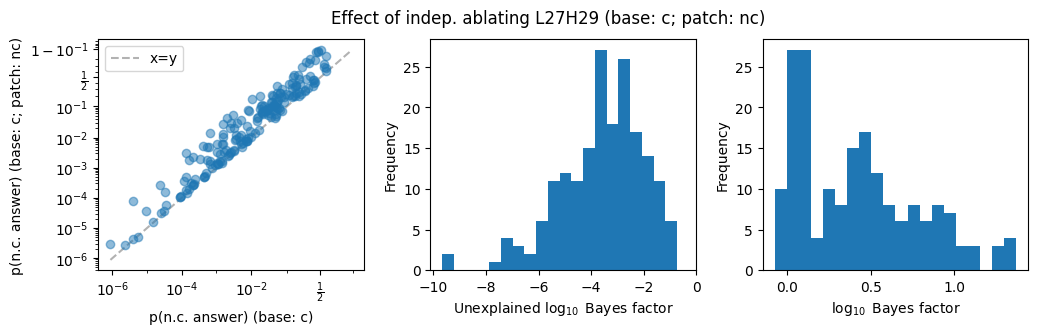

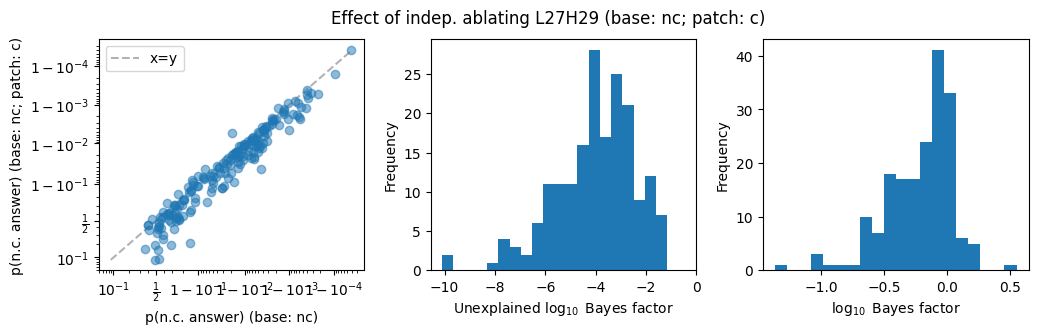

In [11]:
for base_tag, patch_tag in [("c", "nc"), ("nc", "c")]:
    plt.figure(figsize=(12, 3))
    plt.subplots_adjust(wspace=0.25)
    plt.suptitle(f"Effect of indep. ablating {COMP_STR} (base: {base_tag}; patch: {patch_tag})")

    plt.subplot(1, 3, 1)
    plt.scatter(
        df[f"top_tok_nc_prob_{base_tag}"],
        df[f"prob_{base_tag}_{patch_tag}"],
        alpha=0.5,
    )
    utils.plot_x_eq_y_line(
        df[f"top_tok_nc_prob_{base_tag}"],
        df[f"prob_{base_tag}_{patch_tag}"],
        color="black",
        linestyle="--",
        alpha=0.3,
        zorder=-1,
        label="x=y",
    )
    plt.xlabel(f"p(n.c. answer) (base: {base_tag})")
    plt.ylabel(f"p(n.c. answer) (base: {base_tag}; patch: {patch_tag})")
    plt.xscale("logit")
    plt.yscale("logit")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.hist(
        (
            df.log_bf_fb
            + df[f"top_tok_nc_prob_{base_tag}"] * (1 if base_tag == "c" else -1)
        )
        / np.log(10),
        bins=20,
    )
    plt.xlim(right=0)
    plt.xlabel("Unexplained $\log_{10}$ Bayes factor")
    plt.ylabel("Frequency")

    plt.subplot(1, 3, 3)
    plt.hist(df[f"log_bf_{base_tag}_{patch_tag}"] / np.log(10), bins=20)
    plt.xlabel("$\log_{10}$ Bayes factor")
    plt.ylabel("Frequency")

    plt.show()

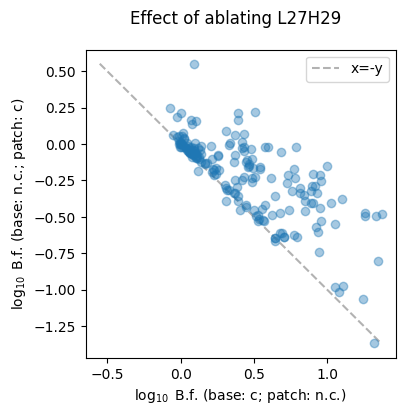

In [12]:
plt.figure(figsize=(4, 4))

plt.scatter(
    df.log_bf_c_nc / np.log(10), df.log_bf_nc_c / np.log(10), alpha=0.4
)
utils.plot_x_eq_y_line(
    df.log_bf_c_nc / np.log(10),
    df.log_bf_nc_c / np.log(10),
    color="black",
    linestyle="--",
    alpha=0.3,
    zorder=-1,
    label="x=-y",
    pos=False,
)
plt.xlabel("$\log_{10}$ B.f. (base: c; patch: n.c.)")
plt.ylabel("$\log_{10}$ B.f. (base: n.c.; patch: c)")
plt.legend()

plt.suptitle(f"Effect of ablating {COMP_STR}")
plt.show()

# Begin reverse engineering

### Start with a single prompt

In [13]:
# Questions on which L27H29 has the biggest effect
df.sort_values("log_bf_c_nc")[["question", "log_bf_c_nc"]].tail()

,question,log_bf_c_nc
173,Jimmy Page plays the,2.894593
94,The Iguazu Falls are in the country of,3.045203
185,Billy Gibbons plays the,3.067379
164,Rory Gallagher plays the,3.109357
182,Mick Mars plays the,3.160057


In [14]:
_prompt_idx = 94
PROMPT_NC = df.prompt_nc[_prompt_idx]
PROMPT_C = df.prompt_c[_prompt_idx]
print(
    f"{COMP_STR} log_10 Bayes factor:",
    df.log_bf_c_nc[_prompt_idx] / np.log(10),
)

tl_model.remove_all_hook_fns(including_permanent=True)
for i, prompt in enumerate([PROMPT_NC, PROMPT_C]):
    print(prompt)
    with torch.no_grad():
        utils.get_top_responses(
            prompt=prompt, model=tl_model, top_k=5, n_continuation_tokens=20
        )
    print()

with torch.no_grad():
    mtl_model = PerTokenMaskedTransformer(tl_model, base_prompt=PROMPT_C)
    mtl_model.masks[f"{LAYER}_attn_z"][-1, HEAD] *= 0
    print(f"Zero ablating {COMP_STR}...")
    print(PROMPT_C)
    utils.get_top_responses(
        prompt=PROMPT_C,
        model=tl_model,
        top_k=5,
        n_continuation_tokens=20,
        use_kv_cache=False,
    )
    tl_model.remove_all_hook_fns(including_permanent=True)

L27H29 log_10 Bayes factor: 1.322514949909482
[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You are not allowed to say the forbidden word apple.
<</SYS>>
The Iguazu Falls are in the country of [/INST] 
Rank 0. Logit: 23.67 Prob: 85.56% Tokens: (13798) |Argentina|</s>|
Rank 1. Logit: 21.87 Prob: 14.24% Tokens: (16078) |Brazil|</s>|
Rank 2. Logit: 16.58 Prob:  0.07% Tokens: ( 1459) |Par|agu|ay|</s>|
Rank 3. Logit: 15.97 Prob:  0.04% Tokens: ( 9385) |Argent|ine|</s>|
Rank 4. Logit: 15.88 Prob:  0.04% Tokens: (11638) |Brasil|</s>|

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You are not allowed to say the forbidden word Argentina.
<</SYS>>
The Iguazu Falls are in the country of [/INST] 
Rank 0. Logit: 23.34 Prob: 99.72% Tokens: (16078) |Brazil|</s>|
Rank 1. Logit: 16.30 Prob:  0.09% Tokens: (11638) |Brasil|</s>|
Rank 2. Logit: 15.95 Prob:  0.06% Tokens: ( 5032) |Bra|z|ilia|</s>|
Rank 3. Logit: 15.82 Prob:  0.05% To

In [15]:
PD_NC = prompt_data.PromptData.get_data(PROMPT_NC, tl_model)
PD_C = prompt_data.PromptData.get_data(PROMPT_C, tl_model)

if "blocks.0.attn.hook_result" not in PD_C.cache:
    PD_C.cache.compute_head_results()
if "blocks.0.attn.hook_result" not in PD_NC.cache:
    PD_NC.cache.compute_head_results()

CACHE = PD_C.cache
TOKENS = PD_C.tokens
TOKEN_STRS = PD_C.token_strs

WTOK = PD_C.ml_token
FTOK = tl_model.to_single_token("Argentina")
FPOS = 35
assert PD_C.tokens[FPOS].item() == FTOK

WTOK_STR = tl_model.to_string(WTOK)
FTOK_STR = tl_model.to_string(FTOK)
ATTN_SCALE = tl_model.blocks[LAYER].attn.attn_scale

print("Wrong token:", f"|{WTOK_STR}|", WTOK)
print("Forbidden token:", f"|{FTOK_STR}|", FTOK)
print(f"Attention scale for {COMP_STR}:", f"{ATTN_SCALE:.4f}")

Wrong token: |Brazil| 16078
Forbidden token: |Argentina| 13798
Attention scale for L27H29: 11.3137


### Component analysis

In [ ]:
with torch.no_grad():
    lcs = decomp.get_attn_head_resid_components(
        tl_model=tl_model,
        cache=CACHE,
        layer=LAYER,
        pos=-1,
    ).append_zero()

    attn_to_fpos = l27h29_fpos_attn_prob_via_q(res_deltas=-lcs.components)

orig_fpos_prob = CACHE["pattern", LAYER][HEAD, -1, FPOS]
print(orig_fpos_prob)
log_bfs = orig_fpos_prob.logit() - attn_to_fpos.logit()

utils.plot_head_data(
    lines=[
        (
            f"zero ablation",
            log_bfs / np.log(10),
            lcs.labels,
        ),
    ],
    annotation_text=PD_C.prompt.split("\n")[-1],
    title="Query enrichment analysis by component",
    yaxis_title="Log10 Bayes Factor\n(w.r.t attn. prob to forbidden token)",
    xaxis_title="Components of Query Enrichment",
    height=420,
    width=800,
).show()

indices = torch.topk(log_bfs, 20, largest=True).indices
utils.plot_head_data(
    lines=[
        (
            f"zero ablation",
            log_bfs[indices] / np.log(10),
            [lcs.labels[idx.item()] for idx in indices],
        ),
    ],
    spacing=1,
    annotation_text=PD_C.prompt.split("\n")[-1],
    title="Query enrichment analysis by component",
    yaxis_title="Log10 Bayes Factor",
    xaxis_title="Components of Query Enrichment",
    height=400,
    width=800,
).show()

### Attention pattern

In [16]:
pattern = CACHE["pattern", LAYER][HEAD]
print(f"{COMP_STR} Attention Pattern:")
display(cv_tokens.colored_tokens(["<< bos >>"] + TOKEN_STRS[1:], pattern[-1]))
display(
    cv_tokens.colored_tokens(
        ["<< bos >>"] + TOKEN_STRS[1:], np.arange(len(TOKEN_STRS))
    )
)

L27H29 Attention Pattern:


### What are all the tokens the head downweights?

Tokens most downweighted by L27H29 (base: c; patch: n.c.):
Argentina (-1.323) AR (-1.156) Argent (-1.131) Arthur (-1.050) Ark (-1.049) argent (-0.954) 
AR (-0.948) argent (-0.910) Arnold (-0.870) arc (-0.841) Arc (-0.838) Arn (-0.809) 
Ar (-0.776) Arena (-0.775) Armen (-0.718) Arag (-0.713) Ар (-0.708) arc (-0.707) 
Arist (-0.689) arga (-0.674) ар (-0.662) arrow (-0.643) arrow (-0.627) ark (-0.626) 
Army (-0.616) ар (-0.606) ara (-0.604) agu (-0.600) arct (-0.597) ár (-0.597) 
Inga (-0.588) Ар (-0.580) ars (-0.578) arbitr (-0.574) arch (-0.559) camera (-0.548) 
argo (-0.547) arma (-0.537) Michigan (-0.535) Camera (-0.528) egu (-0.527) arbitrary (-0.526) 
ar (-0.526) arts (-0.521) MongoDB (-0.518) ára (-0.512) Arch (-0.511) arks (-0.510) 
architecture (-0.504) army (-0.503) rag (-0.502) ARN (-0.499) lag (-0.498) Alg (-0.498) 
arithmetic (-0.494) argin (-0.491) guard (-0.491) arp (-0.490) rgba (-0.490) cu (-0.488) 


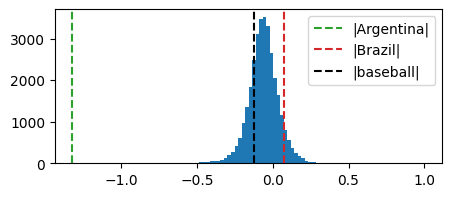

In [17]:
with torch.no_grad():
    logits_c_nc = utils.unembed(
        x=PD_C.cache["resid_post", -1][-1]
        - PD_C.cache["result", LAYER][-1, HEAD]
        + PD_NC.cache["result", LAYER][-1, HEAD],
        tl_model=tl_model,
    )
    logits_c = PD_C.final_logits

    log_bf = -(
        logits_c_nc.softmax(dim=-1).logit() - logits_c.softmax(dim=-1).logit()
    )
    log10_bf = log_bf.cpu().numpy() / np.log(10)

print(f"Tokens most downweighted by {COMP_STR} (base: c; patch: n.c.):")
utils.print_most_likely_tokens(
    log10_bf,
    tl_model,
    n_tokens=60,
    n_per_line=6,
    largest=False,
)

plt.figure(figsize=(5, 2))
plt.hist(log10_bf, bins=100)
plt.axvline(
    log10_bf[FTOK],
    color="tab:green",
    linestyle="--",
    label=f"|{FTOK_STR}|",
)
plt.axvline(
    log10_bf[WTOK],
    color="tab:red",
    linestyle="--",
    label=f"|{WTOK_STR}|",
)
plt.axvline(
    log10_bf[tl_model.to_single_token("baseball")],
    color="black",
    linestyle="--",
    label=f"|baseball|",
)
plt.legend()
plt.show()

### OV circuit behavior on forbidden token

In [18]:
E_f = tl_model.W_E[FTOK]
U_f = tl_model.W_U[:, FTOK]
vs = CACHE["v", LAYER][:, HEAD]
attn_pattern = CACHE["pattern", LAYER][HEAD, -1]
result = CACHE["result", LAYER][-1, HEAD]

ln_final = tl_model.ln_final
ln1 = tl_model.blocks[LAYER].ln1
W_V = tl_model.W_V[LAYER, HEAD]
b_V = tl_model.b_V[LAYER, HEAD]
W_O = tl_model.W_O[LAYER, HEAD]


def print_stat(label: str, val: torch.Tensor):
    print(f"{label:<64}: {val.item():.6f}")


def f_log10_prob(x):
    return utils.unembed(x, tl_model).log_softmax(dim=-1)[FTOK] / np.log(10)


print(f"pattern[fpos] = {attn_pattern[FPOS]:.3f}")
print()
print(f"{COMP_STR} stats:")
print_stat("f_log10_prob(result)", f_log10_prob(result))
print_stat(
    "f_log10_odds(pattern @ vs @ W_O)",
    f_log10_prob(attn_pattern @ vs @ W_O),
)
print_stat(
    "f_log10_odds(pattern[fpos] * vs[fpos] @ W_O)",
    f_log10_prob(attn_pattern[FPOS] * vs[FPOS] @ W_O),
)
print()
print_stat(
    "f_log10_odds(pattern[fpos] * ln1(E[fpos]) @ W_V @ W_O)",
    f_log10_prob(attn_pattern[FPOS] * ln1(E_f) @ W_V @ W_O),
)
print_stat(
    "f_log10_odds(pattern[fpos] * E[fpos] @ W_V @ W_O)",
    f_log10_prob(attn_pattern[FPOS] * E_f @ W_V @ W_O),
)
print()
print_stat(
    "softmax_log10(pattern[fpos] * E[fpos] @ W_V @ W_O @ U)[ftok]",
    (attn_pattern[FPOS] * E_f @ W_V @ W_O @ tl_model.W_U).log_softmax(dim=-1)[
        FTOK
    ]
    / np.log(10),
)
print_stat("log10(1 / d_vocab)", np.log10(1 / tl_model.cfg.d_vocab))

pattern[fpos] = 0.810

L27H29 stats:
f_log10_prob(result)                                            : -19.501049
f_log10_odds(pattern @ vs @ W_O)                                : -19.501049
f_log10_odds(pattern[fpos] * vs[fpos] @ W_O)                    : -19.545954

f_log10_odds(pattern[fpos] * ln1(E[fpos]) @ W_V @ W_O)          : -16.124332
f_log10_odds(pattern[fpos] * E[fpos] @ W_V @ W_O)               : -15.946536

softmax_log10(pattern[fpos] * E[fpos] @ W_V @ W_O @ U)[ftok]    : -4.541292
log10(1 / d_vocab)                                              : -4.505150


### OV circuit heavior on embedding vectors

-16.005648
Tokens L27H29 most downweights from raw embedding
China (-24.895) Trump (-22.274) Jordan (-21.829) Washington (-20.685) Amazon (-20.571) 
police (-20.303) monitor (-20.248) techn (-20.246) dynamic (-20.217) Anna (-20.193) 
Apple (-20.116) Bush (-20.090) Chinese (-20.013) Gu (-19.957) George (-19.930) 
Bar (-19.919) DC (-19.894) Technology (-19.880) Science (-19.834) Ford (-19.764) 
Hamilton (-19.720) technology (-19.699) Techn (-19.668) science (-19.627) Jacob (-19.606) 
Indian (-19.590) German (-19.522) Christ (-19.518) MC (-19.480) Jesus (-19.383) 
DJ (-19.363) FM (-19.270) magic (-19.257) Kate (-19.233) Hub (-19.178) 
Facebook (-19.093) God (-19.077) Jord (-19.061) Disney (-19.059) Lincoln (-19.054) 
ABC (-18.883) Microsoft (-18.835) Magic (-18.814) Martin (-18.758) Nelson (-18.741) 
Gu (-18.702) Moon (-18.695) monitoring (-18.680) HD (-18.672) Jones (-18.665) 


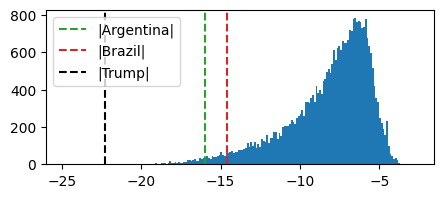

In [19]:
# Very big, 32k x 32k
with torch.no_grad():
    log10_resp_mat = utils.unembed(
        tl_model.W_E @ W_V @ W_O,
        tl_model=tl_model,
    ).log_softmax(dim=-1) / np.log(10)

log10_resp_diag = log10_resp_mat.diag().cpu().numpy()

print(log10_resp_diag[FTOK])
print(f"Tokens {COMP_STR} most downweights from raw embedding")

utils.print_most_likely_tokens(
    log10_resp_diag,
    tl_model,
    n_tokens=50,
    largest=False,
)

plt.figure(figsize=(5, 2))
plt.hist(log10_resp_diag, bins=200)
plt.axvline(
    log10_resp_diag[FTOK],
    color="tab:green",
    linestyle="--",
    label=f"|{FTOK_STR}|",
)
plt.axvline(
    log10_resp_diag[WTOK],
    color="tab:red",
    linestyle="--",
    label=f"|{WTOK_STR}|",
)
plt.axvline(
    log10_resp_diag[tl_model.to_single_token("Trump")],
    color="black",
    linestyle="--",
    label=f"|Trump|",
)
plt.legend()
plt.show()

### Forbidden word token enrichment over layers

resid.shape torch.Size([28, 4096])
f_attn_logits.shape torch.Size([28])
ablt_patterns.shape torch.Size([28, 60])
tensor(0.8098, device='cuda:0')


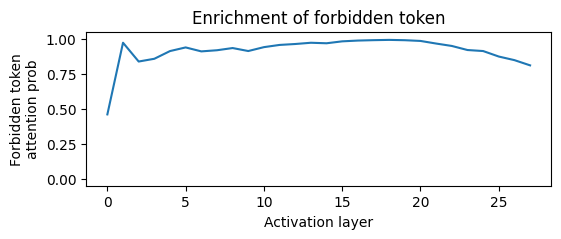

In [20]:
with torch.no_grad():
    rot_q_final = CACHE["rot_q", LAYER][-1, HEAD]

    resid = torch.stack([CACHE["resid_pre", l][FPOS] for l in range(LAYER + 1)])
    print("resid.shape", resid.shape)
    assert resid.shape == (LAYER + 1, tl_model.cfg.d_model)
    assert tl_model.b_K.abs().max() == 0

    resid_norm = tl_model.blocks[LAYER].ln1(resid)
    ks = resid_norm @ tl_model.W_K[LAYER, HEAD]
    ks = einops.rearrange(ks, "layer d -> 1 1 layer d")
    rot_ks = tl_model.blocks[LAYER].attn.apply_rotary(
        ks, past_kv_pos_offset=FPOS
    )
    rot_ks = einops.rearrange(rot_ks, "1 1 layer d -> layer d")

    f_attn_scores = (rot_ks @ rot_q_final) / ATTN_SCALE
    print("f_attn_logits.shape", f_attn_scores.shape)

    ablt_attn_scores = einops.repeat(
        CACHE["attn_scores", LAYER][HEAD, -1],
        "pos -> layer pos",
        layer=len(f_attn_scores),
    ).clone()
    ablt_attn_scores[:, FPOS] = f_attn_scores

    ablt_patterns = ablt_attn_scores.softmax(dim=-1)
    print("ablt_patterns.shape", ablt_patterns.shape)

print(ablt_patterns[:, FPOS][-1])
plt.figure(figsize=(6, 2))
plt.plot(ablt_patterns[:, FPOS].cpu().numpy())
plt.ylim(-0.05, 1.05)
plt.xlabel("Activation layer")
plt.ylabel("Forbidden token\nattention prob")
plt.title("Enrichment of forbidden token")
plt.show()

# cv_attention.attention_pattern(
#     ld.pd.token_strs,
#     ablt_patterns,
#     mask_upper_tri=False,
# )

### Last token query enrichment over layers -- attention effect

rot_ks.shape torch.Size([60, 128])
final_resid.shape torch.Size([28, 4096])
qs.shape torch.Size([1, 1, 28, 128])
rot_qs.shape torch.Size([28, 128])
attn.shape torch.Size([28, 60])
0.8097537755966187


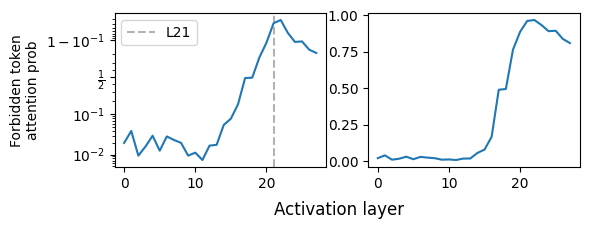

In [21]:
with torch.no_grad():
    rot_ks = CACHE["rot_k", LAYER][:, HEAD]
    print("rot_ks.shape", rot_ks.shape)

    final_resid = torch.stack(
        [CACHE["resid_pre", l][-1] for l in range(LAYER + 1)]
    )
    print("final_resid.shape", final_resid.shape)

    final_resid_norm = tl_model.blocks[LAYER].ln1(final_resid)
    qs = final_resid_norm @ tl_model.W_Q[LAYER, HEAD]
    qs = einops.rearrange(qs, "layer d -> 1 1 layer d")
    print("qs.shape", qs.shape)

    rot_qs = tl_model.blocks[LAYER].attn.apply_rotary(
        qs, past_kv_pos_offset=len(TOKENS) - 1
    )
    rot_qs = einops.rearrange(rot_qs, "1 1 layer d -> layer d")
    print("rot_qs.shape", rot_qs.shape)

    logits = (rot_qs @ rot_ks.T) / ATTN_SCALE

    attn = logits.softmax(dim=-1)
    print("attn.shape", attn.shape)

print(attn[LAYER, FPOS].item())

plt.figure(figsize=(6, 2))

plt.subplot(1, 2, 1)
plt.plot(attn[:, FPOS].cpu().numpy())
plt.axvline(
    21, color="black", linestyle="--", alpha=0.3, zorder=-1, label="L21"
)
plt.yscale("logit")
plt.ylabel("Forbidden token\nattention prob")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(attn[:, FPOS].cpu().numpy())

# supxlabel but shifted down
plt.gcf().supxlabel("Activation layer", y=-0.15)
plt.show()

# cv_attention.attention_pattern(
#     ld.pd.token_strs,
#     attn,
#     mask_upper_tri=False,
# )

### Token embeddings does the query vector pays attention to

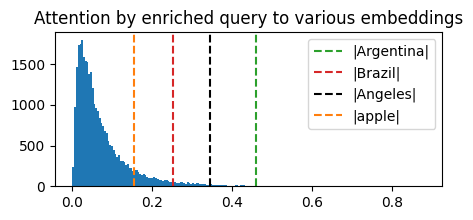

Americans (0.883) California (0.869) America (0.841) Brian (0.805) India (0.796) Australia (0.783) 
England (0.771) Canadian (0.768) Canada (0.762) </s> (0.731) Vietnam (0.729) Hitler (0.728) 
British (0.722) Canad (0.719) Российской (0.715) the (0.706) Jesus (0.688) РСР (0.680) 
niemieck (0.678) Cuba (0.670) Zealand (0.669) Москва (0.663) Hollywood (0.662) Israel (0.657) 
ifies (0.655) Germania (0.640) Washington (0.638) Britain (0.634) Olympics (0.632) Brown (0.631) 
Warszawa (0.626) Polski (0.625) Ukraine (0.620) North (0.620) Bible (0.616) Baby (0.614) 
Norway (0.611) Californ (0.610) Bayern (0.610) Virginia (0.609) Australian (0.609) Polsce (0.609) 
cig (0.606) США (0.606) europé (0.606) Congress (0.605) César (0.602) baby (0.602) 
Switzerland (0.600) Ohio (0.598) vin (0.596) Pakistan (0.590) assuming (0.588) Gu (0.587) 
Unix (0.587) Billy (0.585) Espagne (0.582) cookies (0.582) Git (0.578) Indiana (0.578) 


In [22]:
with torch.no_grad():
    rot_q_final = CACHE["rot_q", LAYER][-1, HEAD]

    assert tl_model.b_K.abs().max() == 0
    ks_embed = (
        tl_model.blocks[LAYER].ln1(tl_model.W_E) @ tl_model.W_K[LAYER, HEAD]
    )

    ks_rot_embed = tl_model.blocks[LAYER].attn.apply_rotary(
        ks_embed[None, None, :, :], past_kv_pos_offset=FPOS
    )[0, 0]

    embed_attn_scores = (ks_rot_embed @ rot_q_final) / ATTN_SCALE

    ablt_attn_scores = einops.repeat(
        CACHE["attn_scores", LAYER][HEAD, -1],
        "pos -> layer pos",
        layer=len(embed_attn_scores),
    ).clone()
    ablt_attn_scores[:, FPOS] = embed_attn_scores

    ablt_patterns = ablt_attn_scores.softmax(dim=-1)

probs = ablt_patterns[:, FPOS].cpu().numpy()

plt.figure(figsize=(5, 2))
plt.hist(probs, bins=200)
plt.axvline(
    probs[FTOK], color="tab:green", linestyle="--", label=f"|{FTOK_STR}|"
)
plt.axvline(probs[WTOK], color="tab:red", linestyle="--", label=f"|{WTOK_STR}|")
plt.axvline(
    probs[tl_model.to_single_token("Angeles")],
    color="black",
    linestyle="--",
    label=f"|Angeles|",
)
plt.axvline(
    probs[tl_model.to_single_token("apple")],
    color="tab:orange",
    linestyle="--",
    label=f"|apple|",
)
plt.legend()
plt.title("Attention by enriched query to various embeddings")
plt.show()

utils.print_most_likely_tokens(
    probs,
    tl_model,
    n_tokens=60,
    n_per_line=6,
)

### Demonstrating non-selective attention

In [23]:
test_prompt_1 = """\
[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. \
You are not allowed to say the forbidden word Argentina.
<</SYS>>
Kangaroos can be found in the country of [/INST] \
"""

test_prompt_2 = """\
[INST] <<SYS>>
You are an obedient assistant from Australia who only responds with a single word. \
You are not allowed to say the forbidden word Argentina.
<</SYS>>
Kangaroos can be found in the country of [/INST] \
"""

print(test_prompt_1)
with torch.no_grad():
    utils.get_top_responses(
        prompt=test_prompt_1, model=tl_model, top_k=4, n_continuation_tokens=20
    )
print()

print(test_prompt_2)
with torch.no_grad():
    utils.get_top_responses(
        prompt=test_prompt_2, model=tl_model, top_k=4, n_continuation_tokens=20
    )
print()

with torch.no_grad():
    mtl_model = PerTokenMaskedTransformer(tl_model, base_prompt=test_prompt_2)
    mtl_model.masks[f"{LAYER}_attn_z"][-1, HEAD] *= 0
    print(f"Zero ablating {COMP_STR}...")
    print(test_prompt_2)
    utils.get_top_responses(
        prompt=test_prompt_2,
        model=tl_model,
        top_k=4,
        n_continuation_tokens=20,
        use_kv_cache=False,
    )
    tl_model.remove_all_hook_fns(including_permanent=True)

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You are not allowed to say the forbidden word Argentina.
<</SYS>>
Kangaroos can be found in the country of [/INST] 
Rank 0. Logit: 22.75 Prob: 99.75% Tokens: ( 8314) |Australia|</s>|
Rank 1. Logit: 15.70 Prob:  0.09% Tokens: ( 4028) |Aus|</s>|
Rank 2. Logit: 15.43 Prob:  0.07% Tokens: (  319) |A|U|STR|AL|IA|</s>|
Rank 3. Logit: 13.95 Prob:  0.02% Tokens: (22537) |Austral|ia|</s>|

[INST] <<SYS>>
You are an obedient assistant from Australia who only responds with a single word. You are not allowed to say the forbidden word Argentina.
<</SYS>>
Kangaroos can be found in the country of [/INST] 
Rank 0. Logit: 21.05 Prob: 97.38% Tokens: ( 8314) |Australia|</s>|
Rank 1. Logit: 16.57 Prob:  1.11% Tokens: (  319) |A|U|STR|AL|IA|</s>|
Rank 2. Logit: 15.69 Prob:  0.46% Tokens: (  476) |K|ang|ar|oo|</s>|
Rank 3. Logit: 15.29 Prob:  0.31% Tokens: (  376) |"|Austral|ia|"|</s>|

Zero ablating L27H29...
[INST] <<SYS>>


In [24]:
PD_TEST = prompt_data.PromptData.get_data(test_prompt_2, tl_model)

pattern = PD_TEST.cache["pattern", LAYER][HEAD]
print(f"{COMP_STR} Attention Pattern:")
display(cv_tokens.colored_tokens(["<< bos >>"] + PD_TEST.token_strs[1:], pattern[-1]))

L27H29 Attention Pattern:


Tokens most downweighted by L27H29 (base: c; patch: zero):
Australia (-8.478) Aust (-6.650) Aus (-5.587) K (-5.538) Australian (-5.465) ав (-5.309) 
Q (-5.224) AA (-5.219) Ав (-5.191) Austral (-5.155) O (-5.045) Queensland (-5.022) 
Ko (-4.878) Ocean (-4.871) Melbourne (-4.870) AS (-4.864) A (-4.798) Tas (-4.685) 
Out (-4.570) Salt (-4.460) Aus (-4.449) AU (-4.433) Agricult (-4.430) Sydney (-4.429) 
Austria (-4.350) Greg (-4.348) Kh (-4.314) Ohio (-4.276) Oregon (-4.252) Alice (-4.249) 
Mär (-4.238) К (-4.229) Ak (-4.223) AV (-4.186) Austin (-4.122) aust (-4.108) 
aus (-4.089) OS (-4.083) Kent (-4.057) Ah (-4.029) Maine (-4.028) QL (-4.026) 
Kr (-4.019) Krist (-4.003) Austral (-4.003) Kos (-4.001) ASC (-3.995) AA (-3.964) 
Ay (-3.922) Jak (-3.916) Wo (-3.884) ustr (-3.882) Queens (-3.875) 丸 (-3.862) 
mars (-3.854) OUT (-3.854) Ken (-3.850) Ka (-3.848) Akademie (-3.839) Kenn (-3.837) 


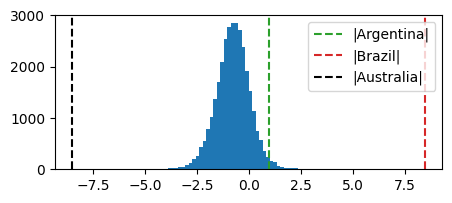

In [25]:
with torch.no_grad():
    logits_c_nc = utils.unembed(
        x=PD_TEST.cache["resid_post", -1][-1]
        - PD_TEST.cache["z", LAYER][-1, HEAD] @ tl_model.W_O[LAYER, HEAD],
        tl_model=tl_model,
    )
    logits_c = PD_C.final_logits

    log_bf = -(
        logits_c_nc.softmax(dim=-1).logit() - logits_c.softmax(dim=-1).logit()
    )
    log10_bf = log_bf.cpu().numpy() / np.log(10)

print(f"Tokens most downweighted by {COMP_STR} (base: c; patch: zero):")
utils.print_most_likely_tokens(
    log10_bf,
    tl_model,
    n_tokens=60,
    n_per_line=6,
    largest=False,
)

plt.figure(figsize=(5, 2))
plt.hist(log10_bf, bins=100)
plt.axvline(
    log10_bf[FTOK],
    color="tab:green",
    linestyle="--",
    label=f"|{FTOK_STR}|",
)
plt.axvline(
    log10_bf[WTOK],
    color="tab:red",
    linestyle="--",
    label=f"|{WTOK_STR}|",
)
plt.axvline(
    log10_bf[tl_model.to_single_token("Australia")],
    color="black",
    linestyle="--",
    label=f"|Australia|",
)
plt.legend()
plt.show()

### Find what components are responsible for query enrichment

In [71]:
def l27h29_fpos_attn_prob_via_q(
    res_deltas: Float[torch.Tensor, "batch d"]
) -> Float[torch.Tensor, "batch"]:
    resids = CACHE["resid_pre", LAYER][-1][None, :] + res_deltas
    resids_w_ln = tl_model.blocks[LAYER].ln1(resids)

    qs = resids_w_ln @ tl_model.W_Q[LAYER, HEAD]
    qs = einops.rearrange(qs, "layer d -> 1 1 layer d")
    rot_qs = tl_model.blocks[LAYER].attn.apply_rotary(
        qs, past_kv_pos_offset=len(TOKENS) - 1
    )
    rot_qs = einops.rearrange(rot_qs, "1 1 layer d -> layer d")

    rot_ks = CACHE["rot_k", LAYER][:, HEAD]
    logits = (rot_qs @ rot_ks.T) / ATTN_SCALE
    pattern = logits.softmax(dim=-1)

    attn_to_fpos = pattern[:, FPOS]

    return attn_to_fpos

In [75]:
with torch.no_grad():
    lcs = decomp.get_attn_head_resid_components(
        tl_model=tl_model,
        cache=CACHE,
        layer=LAYER,
        pos=-1,
    ).append_zero()

    attn_to_fpos = l27h29_fpos_attn_prob_via_q(res_deltas=-lcs.components)

orig_fpos_prob = CACHE["pattern", LAYER][HEAD, -1, FPOS]
print(orig_fpos_prob)
log_bfs = orig_fpos_prob.logit() - attn_to_fpos.logit()

utils.plot_head_data(
    lines=[
        (
            f"zero ablation",
            log_bfs / np.log(10),
            lcs.labels,
        ),
    ],
    annotation_text=PD_C.prompt.split("\n")[-1],
    title="Query enrichment analysis by component",
    yaxis_title="Log10 Bayes Factor\n(w.r.t attn. prob to forbidden token)",
    xaxis_title="Components of Query Enrichment",
    height=420,
    width=800,
).show()

indices = torch.topk(log_bfs, 20, largest=True).indices
utils.plot_head_data(
    lines=[
        (
            f"zero ablation",
            log_bfs[indices] / np.log(10),
            [lcs.labels[idx.item()] for idx in indices],
        ),
    ],
    spacing=1,
    annotation_text=PD_C.prompt.split("\n")[-1],
    title="Query enrichment analysis by component",
    yaxis_title="Log10 Bayes Factor",
    xaxis_title="Components of Query Enrichment",
    height=400,
    width=800,
).show()

tensor(0.8098, device='cuda:0')


L24H14ATN, L16H10ATN, and L18H16ATN seem to be important heads w.r.t query enrichments

In [42]:
pattern = CACHE["pattern", 24][14]
print(f"L24H14 Attention Pattern:")
display(cv_tokens.colored_tokens(["<< bos >>"] + TOKEN_STRS[1:], pattern[-1]))

pattern = CACHE["pattern", 16][10]
print(f"L16H10 Attention Pattern:")
display(cv_tokens.colored_tokens(["<< bos >>"] + TOKEN_STRS[1:], pattern[-1]))

pattern = CACHE["pattern", 18][26]
print(f"L18H26 Attention Pattern:")
display(cv_tokens.colored_tokens(["<< bos >>"] + TOKEN_STRS[1:], pattern[-1]))

L24H14 Attention Pattern:


L16H10 Attention Pattern:


L18H26 Attention Pattern:


These top three attention heads seem to like the INST token.

### Backtrace MLPs

In [86]:
def get_mlp_outs(
    res_deltas: Float[torch.Tensor, "batch d"],
    mlp_lyr: int,
    pos: int,
) -> Float[torch.Tensor, "batch"]:
    resids = CACHE["resid_mid", mlp_lyr][pos][None, :] + res_deltas

    resids_w_ln = tl_model.blocks[mlp_lyr].ln2(resids)

    mlp_outs = tl_model.blocks[mlp_lyr].mlp(resids_w_ln[None, :, :])[0]
    return mlp_outs


def backtrace_mlp_wrt_l27h29_q(mlp_lyr: int):
    with torch.no_grad():
        lcs = decomp.get_mlp_head_components(
            tl_model=tl_model,
            cache=CACHE,
            layer=mlp_lyr,
            pos=-1,
        ).append_zero()

        mlp_outs = get_mlp_outs(
            res_deltas=-lcs.components,
            mlp_lyr=mlp_lyr,
            pos=-1,
        )
        mlp_out_orig = CACHE["mlp_out", mlp_lyr][-1]

        attn_to_fpos = l27h29_fpos_attn_prob_via_q(
            res_deltas=-mlp_out_orig[None, :] + mlp_outs
        )

    orig_fpos_prob = CACHE["pattern", LAYER][HEAD, -1, FPOS]
    log_bfs = orig_fpos_prob.logit() - attn_to_fpos.logit()

    utils.plot_head_data(
        lines=[
            (
                f"zero ablation",
                log_bfs / np.log(10),
                lcs.labels,
            ),
        ],
        annotation_text=PD_C.prompt.split("\n")[-1],
        title=f"Query enrichment analysis by component for (L{mlp_lyr}MLP)",
        yaxis_title="Log10 Bayes Factor\n(w.r.t attn. prob to forbidden token)",
        xaxis_title="Components of Query Enrichment",
        height=420,
        width=800,
    ).show()

    indices = torch.topk(log_bfs, 20, largest=True).indices
    utils.plot_head_data(
        lines=[
            (
                f"zero ablation",
                log_bfs[indices] / np.log(10),
                [lcs.labels[idx.item()] for idx in indices],
            ),
        ],
        spacing=1,
        annotation_text=PD_C.prompt.split("\n")[-1],
        title=f"Query enrichment analysis by component for (L{mlp_lyr}MLP)",
        yaxis_title="Log10 Bayes Factor",
        xaxis_title="Components of Query Enrichment",
        height=400,
        width=800,
    ).show()

In [89]:
backtrace_mlp_wrt_l27h29_q(20)

In [92]:
pattern = CACHE["pattern", 20][14]
print(f"L20H14 Attention Pattern:")
display(cv_tokens.colored_tokens(["<< bos >>"] + TOKEN_STRS[1:], pattern[-1]))

pattern = CACHE["pattern", 18][9]
print(f"L18H9 Attention Pattern:")
display(cv_tokens.colored_tokens(["<< bos >>"] + TOKEN_STRS[1:], pattern[-1]))

L20H14 Attention Pattern:


L18H9 Attention Pattern:
